In [2]:
# from typing import Annotated

# from typing_extensions import TypedDict

# from langgraph.graph import StateGraph, START, END
# from langgraph.graph.message import add_messages


# class State(TypedDict):
#     # Messages have the type "list". The `add_messages` function
#     # in the annotation defines how this state key should be updated
#     # (in this case, it appends messages to the list, rather than overwriting them)
#     messages: Annotated[list, add_messages]


# graph_builder = StateGraph(State)

## Index documents

In [1]:
from byaldi import RAGMultiModalModel
from models.converters import convert_docs_to_pdfs
from logger import get_logger

logger = get_logger(__name__)

def index_documents(folder_path="./data/", index_name='document_index', index_path=None, indexer_model='vidore/colpali'):
    """
    Indexes documents in the specified folder using Byaldi.

    Args:
        folder_path (str): The path to the folder containing documents to index.
        index_name (str): The name of the index to create or update.
        index_path (str): The path where the index should be saved.
        indexer_model (str): The name of the indexer model to use.

    Returns:
        RAGMultiModalModel: The RAG model with the indexed documents.
    """
    try:
        logger.info(f"Starting document indexing in folder: {folder_path}")
        # Convert non-PDF documents to PDFs
        convert_docs_to_pdfs(folder_path)
        logger.info("Conversion of non-PDF documents to PDFs completed.")

        # Initialize RAG model
        RAG = RAGMultiModalModel.from_pretrained(indexer_model)
        if RAG is None:
            raise ValueError(f"Failed to initialize RAGMultiModalModel with model {indexer_model}")
        logger.info(f"RAG model initialized with {indexer_model}.")

        # Index the documents in the folder
        RAG.index(
            input_path=folder_path,
            index_name=index_name,
            store_collection_with_index=True,
            overwrite=True
        )

        logger.info(f"Indexing completed. Index saved at '{index_path}'.")

        return RAG
    except Exception as e:
        logger.error(f"Error during indexing: {str(e)}")
        raise

RAG = index_documents()

/home/aryaman/Desktop/batcave/local-gpt-Vision/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-13 18:29:47,188 - INFO - __main__ - Starting document indexing in folder: ./data/
2025-01-13 18:29:47,189 - INFO - __main__ - Conversion of non-PDF documents to PDFs completed.


Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it]
2025-01-13 18:29:59,939 - INFO - __main__ - RAG model initialized with vidore/colpali.


overwrite is on. Deleting existing index document_index to build a new one.
Indexing file: data/document.pdf
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.


2025-01-13 18:30:05,915 - INFO - __main__ - Indexing completed. Index saved at 'None'.


Index exported to .byaldi/document_index
Index exported to .byaldi/document_index


In [2]:
from dataclasses import dataclass

@dataclass
class DocInfo:
    document_id: str
    page_number: int
    base64: str

In [3]:
from langchain.tools import tool
import os
import base64
from PIL import Image
from io import BytesIO
import hashlib
import pprint

# @tool
# def retrieve_documents_tool(query: str, k: int = 3) -> list:
def retrieve_documents_tool(state, k: int = 3) -> list:
    """
    Retrieves relevant documents based on the user query using Byaldi.

    Args:
        query (str): The user's query.
        session_id (str): The session ID to store images in per-session folder.
        k (int): The number of documents to retrieve.

    Returns:
        list: A list of image filenames corresponding to the retrieved documents.
    """
    try:
        session_id = 'temp'

        messages = state["messages"]
        query = messages[0].content
        results = RAG.search(query, k=k)
        pprint.pprint(results)
        
        images = []
        session_images_folder = os.path.join('static', 'images', session_id)
        os.makedirs(session_images_folder, exist_ok=True)

        for result in results:
            if result.base64:
                
                image_data = base64.b64decode(result.base64)
                image = Image.open(BytesIO(image_data))

                # Generate a unique filename based on the image content
                image_hash = hashlib.md5(image_data).hexdigest()
                image_filename = f"retrieved_{image_hash}.png"
                image_path = os.path.join(session_images_folder, image_filename)

                if not os.path.exists(image_path):
                    image.save(image_path, format='PNG')
                    
                # Store the relative path from the static folder
                relative_path = os.path.join('images', session_id, image_filename)

                doc_info = DocInfo(document_id=result.doc_id, page_number=result.page_num, base64=result.base64)
                images.append(doc_info)
                
        return {"images": images, "messages": [f"Retrieved images from the db."]}
    
    except Exception as e:
        raise RuntimeError(f"Error retrieving documents: {e}")

In [4]:
tools = [retrieve_documents_tool]

In [5]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    images: Sequence[DocInfo]
    updated_additional_information: Sequence[str]
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [6]:
from typing import Literal
import re

def check_query_type(state) -> Literal["admin_update_query", "user_general_query"]:
    """
    Determines whether it is an update query or not.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
        admin_update_query - if it is an update query
        user_general_query - if it is not an update query
    """

    print("---CHECK RELEVANCE---")

    pattern = r'^~UPDATE'
    messages = state["messages"]
    question = messages[0].content
    

    if re.match(pattern, question):
        print("---DECISION: UPDATE QUERY---")
        return "admin_update_query"

    else:
        print("---DECISION: GENERAL QUERY---")
        return "user_general_query"


In [7]:
from typing import Dict, List, Optional
import sqlite3
import json
from datetime import datetime
from dataclasses import dataclass
import re
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

@dataclass
class UpdateEntry:
    document_id: int
    page_number: int
    update_text: str
    timestamp: str

class UpdatesDatabase:
    def __init__(self, db_path: str = "updates.db"):
        self.db_path = db_path
        self.init_db()
    
    def init_db(self):
        """Initialize the SQLite database with required tables."""
        with sqlite3.connect(self.db_path) as conn:
            conn.execute("""
                CREATE TABLE IF NOT EXISTS updates (
                    document_id INTEGER,
                    page_number INTEGER,
                    update_text TEXT,
                    timestamp TEXT,
                    PRIMARY KEY (document_id, page_number)
                )
            """)
    
    def store_update(self, entry: UpdateEntry):
        """
        Upsert an update entry in the database.
        If the document_id and page_number combination exists, update the entry;
        otherwise, insert a new entry.
        """
        with sqlite3.connect(self.db_path) as conn:
            conn.execute("""
                INSERT INTO updates (document_id, page_number, update_text, timestamp)
                VALUES (?, ?, ?, ?)
                ON CONFLICT(document_id, page_number) DO UPDATE SET
                    update_text = excluded.update_text,
                    timestamp = excluded.timestamp
            """, (
                entry.document_id,
                entry.page_number,
                entry.update_text,
                entry.timestamp
            ))
    
    def get_update(self, document_id: int, page_number: int) -> UpdateEntry:
        """Retrieve a specific update entry by document_id and page_number."""
        with sqlite3.connect(self.db_path) as conn:
            cursor = conn.execute(
                """
                SELECT * FROM updates 
                WHERE document_id = ? AND page_number = ?
                """,
                (document_id, page_number)
            )
            row = cursor.fetchone()
            if row:
                return UpdateEntry(
                    document_id=row[0],
                    page_number=row[1],
                    update_text=row[2],
                    timestamp=row[3]
                )
            return None

    def generate_relevant_update_text(self, document_id: str, page_number: int, current_update_text: str) -> str:
        """
        Generate the relevant update text for a document page by merging existing and current updates.
        
        Args:
            document_id (str): The ID of the document
            page_number (int): The page number
            current_update_text (str): The new update text to be merged
        
        Returns:
            str: The merged update text
        """
        existing_update = self.get_update(document_id, page_number)
        if not existing_update:
            return current_update_text
        
        # Make a Groq API call to process the merged text
        api_key = 'GROQ_API_KEY'
        llm = ChatGroq(
            model="llama-3.3-70b-versatile",
            api_key=api_key
        )
        
        prompt = ChatPromptTemplate.from_messages([
            (
                "system",
                '''You are a relevant context merger. Your task is to merge the text within <existing_update_text></existing_update_text> with the text within <current_update_text></current_update_text>. If you find some information is conflicting, give priority to <current_update_text>. If you find some information is different, you can merge the two texts.
                Only give the final merged text as the response. Do not include any other information or text in the response.'''
            ),
            (
                "user",
                '''The existing update text is as follows:
                <existing_update_text>
                {existing_text}
                </existing_update_text>
                
                The current update text is as follows:
                <current_update_text>
                {current_text}
                </current_update_text>'''
            )
        ])

        # Format the messages with actual content
        formatted_messages = prompt.format_messages(
            existing_text=existing_update.update_text,
            current_text=current_update_text
        )
        
        try:
            # Get response from LLM
            response = llm.invoke(formatted_messages)
            
            # Extract and return the content
            if response and hasattr(response, 'content'):
                return response.content.strip()
            else:
                raise ValueError("Invalid response from LLM")
                
        except Exception as e:
            print(f"Error generating merged text: {str(e)}")
            # In case of error, return the current update text as fallback
            # return current_update_text

            raise ValueError("Error generating merged text")


    # Add this method to the UpdatesDatabase class for easier usage
    def update_with_merge(self, document_id: str, page_number: int, update_text: str):
        """
        Update a document page with text merging capability.
        
        Args:
            document_id (str): The ID of the document
            page_number (int): The page number
            update_text (str): The new update text
        """
        # Generate merged text
        merged_text = self.generate_relevant_update_text(
            document_id,
            page_number,
            update_text
        )
        
        # Create and store the update
        entry = UpdateEntry(
            document_id=document_id,
            page_number=page_number,
            update_text=merged_text,
            timestamp=datetime.now().isoformat()
        )
        
        self.store_update(entry)
        return merged_text

In [8]:
def update_updatesDB(state):
    """
    Updates the documents based on the user query.
    
    Args:
        state (messages): The current state containing the update query
    
    Returns:
        dict: A message indicating the success or failure of the update
    """
    print("---UPDATE DOCUMENTS---")
    try:
        messages = state["messages"]
        query = messages[0].content
        
        # Parse the update query
        # Expected format: ~UPDATE: doc_id | page_number | update_text
        if not query.startswith("~UPDATE:"):
            return {"messages": ["Invalid update format. Expected: ~UPDATE: update_text"]}
        
        text = query[8:]
        
        # Initialize database
        updates_db = UpdatesDatabase()

        try:
            for image in state["images"]:
                doc_id = image.document_id
                page_number = image.page_number
                update_text = text

                merged_text = updates_db.update_with_merge(
                    document_id = doc_id,
                    page_number = page_number,
                    update_text = update_text
                )
            
            return {
                "messages": [
                    "all pages updated successfully"
                ]
            }
        except Exception as e:
            return {"messages": [f"Error during merge: {str(e)}"]}

    except Exception as e:
        return {"messages": [f"Error processing update: {str(e)}"]}
        

In [9]:
def fetch_updatesDB(state):
    """
    Fetches the relevant documents based on the user query.

    Args:
        state (messages): The current state
        query (str): The user's query

    Returns:
        str: A message indicating the success of the fetch
    """

    print("---FETCH DOCUMENTS---")

    try:
        # Initialize updates database
        updates_db = UpdatesDatabase()
        
        combined_results = []

        # print("STATE IMAGES ", state["images"])

        for result in state["images"]:
            # Extract document ID and page number from DB
            # Assuming RAG results contain this information in metadata
            doc_id = result.document_id
            page_number = result.page_number

            print(doc_id, page_number, doc_id is not None and page_number is not None)
            
            if doc_id is not None and page_number is not None:
                # Check for updates
                update = updates_db.get_update(doc_id, page_number)
                if update:
                    combined_results.append(update.update_text)
        
        # Store the combined results in state for use by generate_response
        return {
            "updated_additional_information": combined_results,
            "messages": [f"Retrieved updates for {len(combined_results)} documents."]
            }
        
    except Exception as e:
        return f"Error fetching documents: {e}"

In [15]:
from langchain_core.messages import HumanMessage

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

def generate_response(state):
    """
    Generates a response based on the user query.

    Args:
        state (messages): The current state
        query (str): The user's query

    Returns:
        str: A message indicating the success of the response
    """

    print("---GENERATE RESPONSE---")

    try:
        api_key = 'GROQ_API_KEY'
        llm = ChatGroq(
            api_key=api_key,
            model_name="llama-3.2-90b-vision-preview",
            temperature=0.1
        )
        
        generated_text = ""
        
        # Process each image
        for img in state["images"]:
            # Construct the message content
            content = [
                {
                    "type": "text",
                    "text": "You are a text extraction tool. Extract and return ONLY the exact text visible in the image. Do not describe the image, background or add any commentary. Format the text exactly as it appears, maintaining headings, lists and structure. Do not add any additional formatting or descriptions. For tables, output each row in this exact format: {row_number}. {column1} - {column2}. Do not add any other text or descriptions."
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{img.base64}"
                    }
                }
            ]
            
            # Create message
            message = HumanMessage(content=content)
            
            # Get completion
            response = llm.invoke([message])
            
            # Append response
            generated_text += response.content
            generated_text += "\n\n"
            
            # print(generated_text)


        api_key = 'GROQ_API_KEY'
        llm = ChatGroq(
            model='llama-3.3-70b-versatile',
            api_key=api_key
        )

        prompt = ChatPromptTemplate.from_messages([
            (
                "system",
                '''Your task is to answer queries strictly based on the provided context and updated additional information. 
                If there is conflicting information between the context and the updated additional information, always prioritize the updated additional information. 
                Provide concise and accurate answers that directly address the query, avoiding any unnecessary details. 
                If the answer cannot be determined from the provided information, respond with "I don't know."'''
            ),
            (
                "user",
                '''
                Here is a query and the relevant details to help you generate a response:

                Query:
                {query}

                Context:
                {context}

                Updated Additional Information (if available):
                {updated_additional_information}

                Use the context and updated additional information to answer the query, following the instructions provided.'''
            )
        ])

        # Format the messages with actual content
        formatted_messages = prompt.format_messages(
            query = state["messages"][0].content,
            context = generated_text,
            updated_additional_information = '\n'.join(state["updated_additional_information"])
        )

        response = llm.invoke(formatted_messages)

        print(response.content)

        return {"messages": [response.content]}

        # return {"messages": [f"Response generated successfully."]}
    except Exception as e:
        raise RuntimeError(f"Error generating response: {e}")
        # return f"Error generating response: {e}"

In [ ]:
# api_key = os.getenv("GROQ_API_KEY")
# if not api_key:
#     raise ValueError("GROQ_API_KEY not found in .env file")

In [11]:
from langchain_groq import ChatGroq

def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")

    messages = state["messages"]

    api_key = 'GROQ_API_KEY'
    if not api_key:
        raise ValueError("GROQ_API_KEY not found in .env file")
    model = ChatGroq(api_key=api_key)

    # model = model.bind_tools(tools)
    response = model.invoke(messages)

    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [16]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)  # agent
workflow.add_edge(START, "agent") # Call agent node to decide to retrieve or not

workflow.add_node("retrieve", retrieve_documents_tool)  # retrieval
workflow.add_node("admin_update_query", update_updatesDB)  # update
workflow.add_node("user_general_query", fetch_updatesDB)  # fetch
workflow.add_node("generate_response", generate_response)  # generate_response

workflow.add_edge(START, "agent")

# Decide whether to retrieve
# workflow.add_conditional_edges(
#     "agent",
#     # Assess agent decision
#     tools_condition,
#     {
#         # Translate the condition outputs to nodes in our graph
#         "tools": "retrieve",
#         END: END,
#     },
# )

workflow.add_edge("agent", "retrieve")

workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    check_query_type,
)

# ["admin_update_query", "user_general_query"]
workflow.add_edge("admin_update_query", END)

workflow.add_edge("user_general_query", "generate_response")
workflow.add_edge("generate_response", END)

# Compile
graph = workflow.compile()

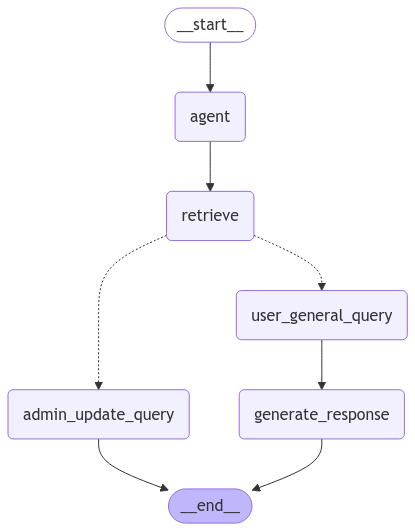

In [13]:
from IPython.display import display
import IPython.display as ipd

try:
    display(ipd.Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [22]:
import pprint

inputs = {
    "messages": [
    # ("user", "~UPDATE: pan verification is now provided by abc"),
    # ("user", "~UPDATE: Account Aggregator service is now provided by yxz"),
    # ("user", "Dont do anything"),
        ("user", "who provides the pan verification service?")
        # ("user", "explain the LAS Digital Onboarding Journey?")
    # ("user", "what are the LMS Global Configurations?")    
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        # pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
'\n---\n'
[{'doc_id': 0, 'page_num': 3, 'score': 17.75, 'metadata': {}, 'base64': 'iVBORw0KGgoAAAANSUhEUgAABnsAAAkjCAIAAABGVW0iAAEAAElEQVR4nOzdd5he11Uv/u/ae5/ylqkajbrk3u3YsVPsxGmEEEgFAgFCuXAvNYUQbiEQCLlwQ7vAjxLgUhICgQChJqGEFNJd4sSOW1xkW72Opr3tlL33+v0xkmzLI1m2R5qR+X6eefTMvDrnvPucGfl55uu19pKxb7sFREREREREREREtETMci+AiIiIiIiIiIjoaYWJGxERERERERER0VJi4kZERERERERERLSUmLgREREREREREREtJSZuRERERERERERES4mJGxERERERERER0VJi4kZERERERERERLSUmLgREREREREREREtJSZuRERERERERERES4mJGxERERERERER0VISVV3uNRARERERERERET19sMaNiIiIiIiIiIhoKTFxIyIiIiIiIiIiWkpM3IiIiIiIiIiIiJYSEzciIiIiIiIiIqKlxMSNiIiIiIiIiIhoKTFxIyIiIiIiIiIiWkpM3IiIiIiIiIiIiJYSEzciIiIiIiIiIqKlxMSNiIiIiIiIiIhoKTFxIyIiIiIiIiIiWkpM3IiIiIiIiIiIiJYSEzciIiIiIiIiIqKlxMSNiIiIiIiIiIhoKTFxIyIiIiIiIiIiWkpM3IiIiIiIiIiIiJYSEzciIiIiIiIiIqKlxMSNiIiIiIiIiIhoKTFxIyIiIiIiIiIiWkpM3IiIiIiIiIiIiJYSEzciIiIiIiIiIqKlxMSNiIiIiIiIiIhoKTFxIyIiIiIiIiIiWkpM3IiIiIiIiIiIiJYSEzciIiIiIiIiIqKlxMSNiIiIiIiIiIhoKTFxIyIiIiIiIiIiWkpM3I